### Acknowledgement

*This notebook contains several excerpts from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the original content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).* 

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*


## Overview

The objective is to expose some of the methods and to show some visualizations, since this is a key aspect of dimensionality reduction and clustering. We will use the ``Seaborn`` visualization package which builds on and extends the capabilities of the standard ``Matplotlib`` package. *You will need to install these if you want to run this notebook locally.*

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()      #sns.set()?

import pandas as pd
# pandas.__version__


##  Principal Component Analysis (PCA)

Principal component analysis is an unsupervised method for dimensionality reduction that is designed to search for a set of linear combinations of the original features. If this set of new features is smaller than the set of original features, it forms a *sub-space* onto which the data can be projected, reducing the number of dimensions. PCA is easiest to visualize by looking at a two-dimensional dataset. Consider the following 200 points:

(-2.7292712056271964,
 2.5702744393352615,
 -0.9326181575178751,
 1.004413830229183)

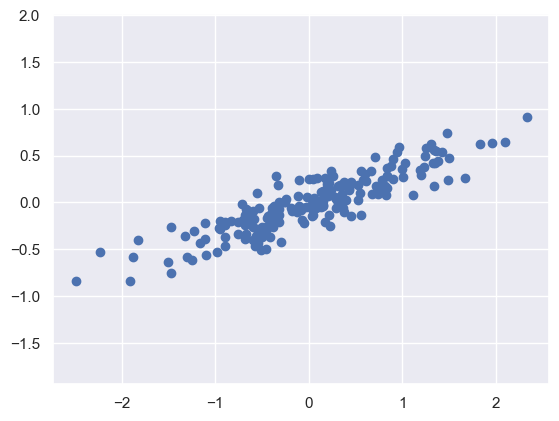

In [2]:
rng = np.random.RandomState(1)
A=rng.rand(2, 2)
B=rng.randn(2, 200)
X = np.dot(A,B).T # x.T is x transposed
plt.scatter(X[:, 0], X[:, 1]) #200 pairs of random points
plt.axis('equal')


In [7]:
print(type(X))
print(type(A))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Clearly there is a nearly linear relationship here between the two axes.
We could apply linear regression to model the dependency of the y values on the x values, but the problem setting here is slightly different: rather than attempting to *predict* the y values from the x values, the unsupervised learning problem attempts to learn about the *relationship* between the x and y values. To do this, PCA zero-centres the data matrix, generates the covariance matrix, then applies a Singular Value Decomposition (SVD), as outlined in the lecture notes. However, here we simply call Scikit-Learn's ``PCA`` estimator to do this. PCA will return a list of the orthogonal *principal axes* (eigenvectors) in the data, ordered in terms of decreasing variance (decreasing eigenvalues).

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [9]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [10]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

0.7625315008826112 [-0.94446029 -0.32862557]
---vector [ 0.03351168 -0.00408072] [2.50770626 0.85681689]
0.018477895513562572 [-0.32862557  0.94446029]
---vector [ 0.03351168 -0.00408072] [ 0.16752528 -0.38923188]
---variance and components [0.7625315 0.0184779] [[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


(-2.7292712056271964,
 2.5702744393352615,
 -0.9326181575178751,
 1.004413830229183)

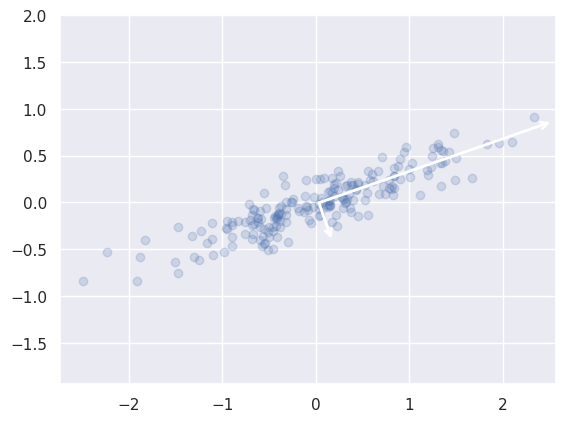

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_): #picks one from the first and one from the second
    print(length,vector)
    v = vector * 3 * np.sqrt(length) # 3 to make vec visible
    print("---vector",pca.mean_, pca.mean_ - v)
    draw_vector(pca.mean_, pca.mean_ - v)   # what is it drawing actually?
print("---variance and components",pca.explained_variance_, pca.components_) # expl vari is for each compone
plt.axis('equal')

These **vectors represent the *principal axes* of the data**, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a **measure of the variance** of the data when projected onto that axis.
The projection of each data point onto the principal axes are the "principal components" of the data.

This transformation from data axes to principal axes is an *affine transformation*, which basically means it is composed of a translation, rotation, and uniform scaling, which is implemented by the SVD algorithm.

While this algorithm to find principal components may seem like just a mathematical curiosity, it turns out to have very far-reaching applications in the world of machine learning and data exploration.

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves *zeroing out* one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance. (You can think of this as setting the eigenvalues below some threshold in the diagonal matrix to zero).

Here is an example of using PCA as a dimensionality reduction transform:

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

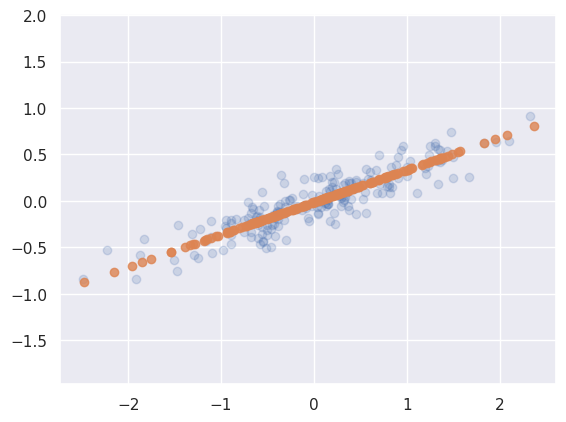

In [8]:
X_new = pca.inverse_transform(X_pca)
# after removing one axis with lowest variance, transforming and transforming back
# print(X[:10,:])
# print(X_pca[:10,:])
# print(X_new[:10,:])
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: ***the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance***.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.
To see this, let's take a quick look at the application of PCA to the built-in digits dataset.

We start by loading the data:

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional.
To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [13]:
pca = PCA(n_components=2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data:

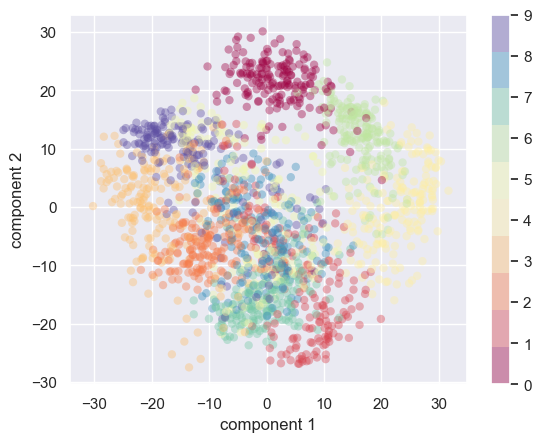

In [16]:
import matplotlib.cm

plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.4,
            # cmap=plt.cm.get_cmap('spectral', 10))
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.
Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels. The set of examples for each digit has been colour-coded using the key on the right. This is the sense in which PCA can provide a low-dimensional representation of the data: it discovers a set of functions (linear combinations of the original features) that are more efficient at encoding the data than the native pixel features of the input data.


### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative *explained variance ratio*.

On the cumulative *explained variance ratio* plot, we want to find the turning point where its cumulative *explained variance ratio*  reach one threshold.

Text(0, 0.5, 'cumulative explained variance')

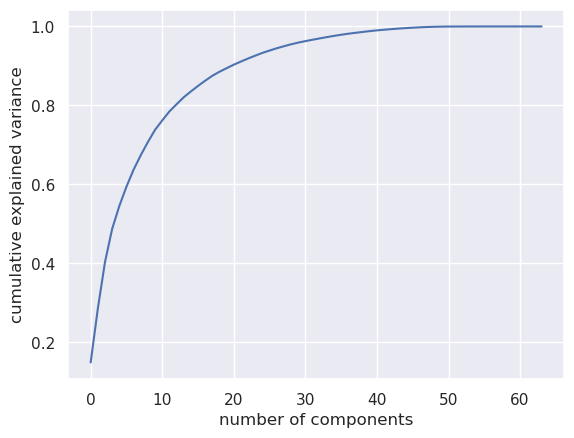

In [12]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_)) #perc of variance for this dim of the sum of variance
# print(pca.explained_variance_ratio_) # cuml of % of var, goes to 1
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.
For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

<h1><center> Task - 1 </center></h1>
Implementing PCA on Iris Dataset

In this task, you will implement PCA on the famous Iris dataset using Python. The Iris dataset is a commonly used dataset for learning about PCA and is available in many machine learning libraries, including scikit-learn.

    1. Import the necessary libraries and load the Iris dataset.
    2. Standardize the data.
    3. Perform PCA on the standardized data using scikit-learn.
    4. Visualize the results by plotting the principal components.
    5. Interpret the results of the PCA.
    (Optional) Cross-validate the results using a k-fold cross-validation approach.

In [17]:
from sklearn import datasets
iris = datasets.load_iris()

In [21]:
print(type(iris))
print(iris)

<class 'sklearn.utils.Bunch'>
{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
    

In [27]:
from sklearn.preprocessing import StandardScaler
obj = StandardScaler()
y = iris.target
print(y.shape)
x = iris.data
x_ = obj.fit_transform(x)
print(x_)

(150,)
[[-9.00681170e-01  1.01900435e+00 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00 -1.31979479e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.38535265e+00  3.28414053e-01 -1.39706395e+00 -1.31544430e+00]
 [-1.50652052e+00  9.82172869e-02 -1.28338910e+00 -1.31544430e+00]
 [-1.02184904e+00  1.24920112e+00 -1.34022653e+00 -1.31544430e+00]
 [-5.37177559e-01  1.93979142e+00 -1.16971425e+00 -1.05217993e+00]
 [-1.50652052e+00  7.88807586e-01 -1.34022653e+00 -1.18381211e+00]
 [-1.02184904e+00  7.88807586e-01 -1.28338910e+00 -1.31544430e+00]
 [-1.74885626e+00 -3.62176246e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00  9.82172869e-02 -1.28338910e+00 -1.44707648e+00]
 [-5.37177559e-01  1.47939788e+00 -1.28338910e+00 -1.31544430e+00]
 [-1.26418478e+00  7.88807586e-01 -1.22655167e+00 -1.31544430e+00]
 [-1.26418478e+00 -1.31979479e-01 -1.34022653e+00 -1.44707648e+00]
 [-1.87002413e+00 -1.31979479e-01 -1.51073881e+00 -1.44707648e+00]
 [-5.25060772e-02  2.16998818e+00 -1.45390138e+00 -1.31

IndexError: index 2 is out of bounds for axis 1 with size 2

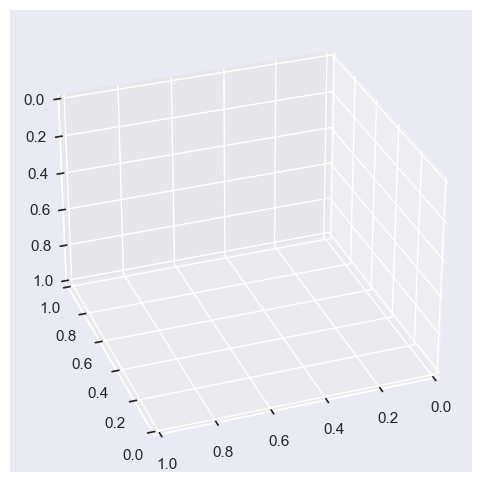

In [28]:
pca = PCA()
numbers = [2,3,5,9,22,39]

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
for i in numbers:
    X_reduced = PCA(n_components=i).fit_transform(iris.data)
    ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        X_reduced[:, 2],  # issue with i
        c=y,
        cmap=plt.cm.Set1,
        edgecolor="k",
        s=40,
    )

    ax.set_title("First %i PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.zaxis.set_ticklabels([])

    plt.show()

## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free data:

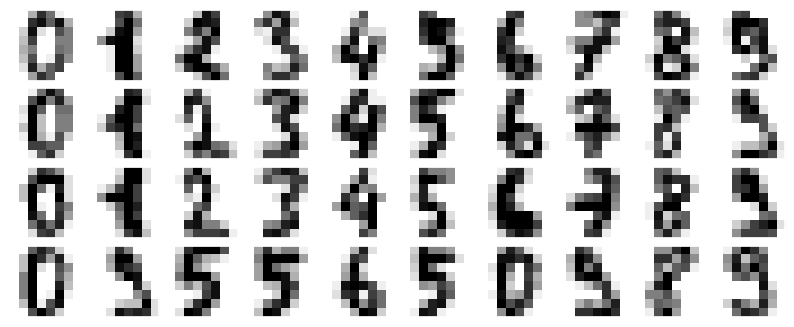

In [29]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now lets add some random noise to create a noisy dataset, and re-plot it:

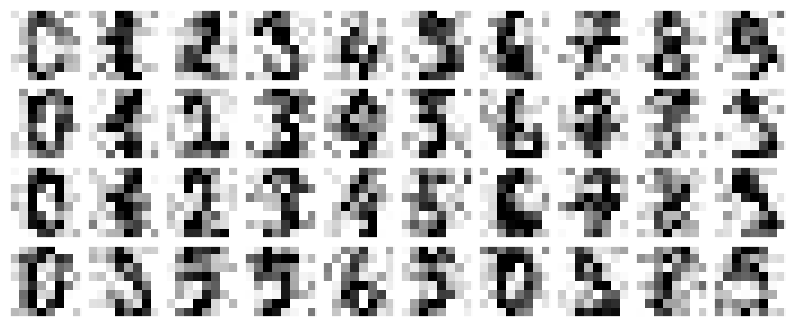

In [30]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It's clear by eye that the images are noisy, and contain spurious pixels.
Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

In [31]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components.
Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

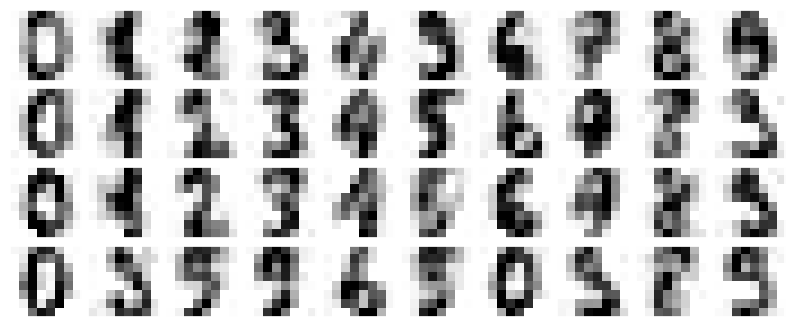

In [32]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

## Example: Eigenfaces

This example applies a PCA projection to facial image data 
using the Labeled Faces in the Wild dataset made available through Scikit-Learn:

In [33]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's take a look at the principal axes that span this dataset.
Because this is a large dataset, we will use a ``Randomized`` version of PCA which contains a randomized method to approximate the first $N$ principal components **much more quickly** than the standard ``PCA`` estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000).
We will take a look at the first 150 components:

In [18]:
# RandomizedPCA is deprecated, do this
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)
pca = PCA(n_components=150,svd_solver='randomized').fit(faces.data)

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors,"
so these types of images are often called "eigenfaces").
As you can see in this figure, they are as creepy as they sound:

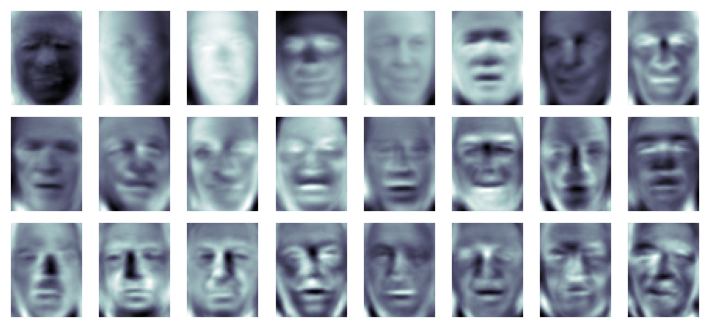

In [19]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

<Figure size 640x480 with 0 Axes>

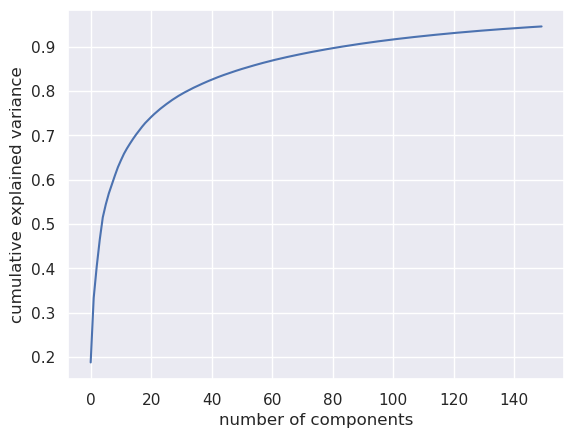

<Figure size 640x480 with 0 Axes>

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.figure()

We see that these 150 components account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components:

In [21]:
# Compute the components and projected faces
#pca = RandomizedPCA(150).fit(faces.data)
pca = PCA(n_components=150,svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

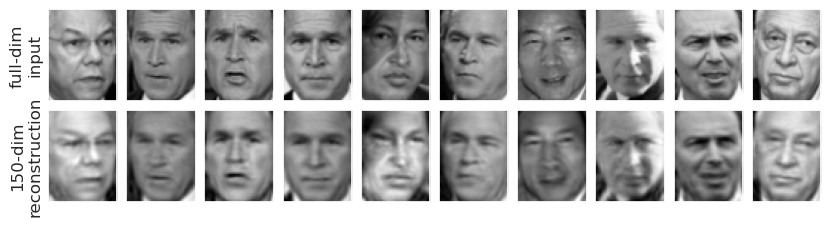

In [22]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.
This visualization makes clear why the PCA feature selection can be so successful: although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image.
What this means is that following this dimensionality reduction a classification algorithm can  be trained on 150-dimensional data rather than 3,000-dimensional data, which, depending on the particular algorithm we choose, can lead to a much more efficient classification.

### Principal Component Analysis Summary

In this section we have discussed the use of principal component analysis for dimensionality reduction, for visualization of high-dimensional data, for noise filtering, and for feature selection within high-dimensional data.
Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines.
Given any high-dimensional dataset, I tend to start with PCA in order to visualize the relationship between points (as we did with the digits), to understand the main variance in the data (as we did with the eigenfaces), and to understand the intrinsic dimensionality (by plotting the explained variance ratio).
Certainly PCA is not useful for every high-dimensional dataset, but it offers a straightforward and efficient path to gaining insight into high-dimensional data.

PCA has two main weaknesses: first, it assumes that the principal components are linear combinations (which may not be appropriate if non-linear dimensions will be required) and second, it tends to be highly affected by outliers in the data.
For these reasons, it may be necessary to use non-linear dimensionality reduction algorithms (such as *Isomap*, *LLE*, etc.) or robust PCA methods (such as *RandomizedPCA*, as used above).

<h1><center> Task -2 </center></h1>

## PCA for Noise Filtering

In this task, you will apply PCA for noise filtering on a color images dataset in Python. Noise filtering is a common application of PCA, where principal components are used to remove noise from the data.

    1. Load the "Olivetti-faces" dataset from Keras.
    2. Add random noise to the dataset.
    3. Visualize the dataset.
    4. Reshape the data into 2D array.
    5. Standardize the data.
    6. Perform PCA on the standardized data.
    7. Determine the number of principal components to keep based on the explained variance.
    8. Reconstruct the data using the selected principal components.
    9. Visualize the reconstructed data and compare it to the original data.
    10. Interpret the results of the PCA.

<h1><center> MICE </center></h1>

MICE (Multiple Imputation by Chained Equations) is a popular method for imputing missing values in a dataset. It involves imputing the missing values multiple times and creating multiple complete datasets, which are then combined to obtain the final imputed dataset.

The MICE algorithm works by imputing one variable at a time, conditional on the other variables in the dataset. The algorithm iteratively imputes missing values in each variable using a regression model that includes all the other variables as predictors. This is repeated for each variable in the dataset, until convergence is reached.

Here's an example of how MICE works:

Suppose we have a dataset with 3 variables: age, income, and education, and we have missing values in the income variable. We want to impute the missing values using MICE.

    First, we impute the missing values in the income variable using a regression model that includes the age and education variables as predictors.

    Next, we impute the missing values in the age variable using a regression model that includes the income and education variables as predictors.

    Finally, we impute the missing values in the education variable using a regression model that includes the age and income variables as predictors.

We repeat these steps until convergence is reached, that is, until the imputed values stop changing. The result is a complete dataset with imputed values for the missing values.


In [6]:
from fancyimpute import IterativeImputer
import numpy as np

# create a sample dataset with missing values
X = np.random.normal(size=(100, 5))
missing_mask = np.random.rand(*X.shape) < 0.1
X_missing = X.copy()
X_missing[missing_mask] = np.nan

# impute missing values using MICE
imputer = IterativeImputer()
X_imputed = imputer.fit_transform(X_missing)


In this example, we create a sample dataset with 5 variables and introduce missing values in 10% of the data. We then use the IterativeImputer class from the fancyimpute library to impute the missing values using the MICE algorithm. The resulting X_imputed array contains the imputed values for the missing values in the original dataset.

<h1><center> Task - 3 </center></h1>

    1. Load the "Ames House Prices" dataset and introduce missing values in the data. You can randomly remove 10% of the data as missing values.

    2. Visualize the missing values in the dataset using a heatmap.

    3. Impute the missing values using the MICE algorithm in the fancyimpute library.

    4. Compare the imputed dataset to the original dataset using summary statistics and visualization.

Useful Library: !pip install fancyimpute

<h1><center> Important Concepts </center></h1>

## Regularization

Regularization is a technique used to prevent overfitting in machine learning models. It involves adding a penalty term to the model's loss function that discourages the model from assigning too much importance to certain features. There are several types of regularization, including L1, L2, and elastic net.

## Chi-Square Test

The chi-square test is a statistical test used to determine if there is a significant association between two categorical variables. The test involves calculating the difference between the observed frequencies and the expected frequencies, and then using a chi-square distribution to calculate a p-value.



Chi-square statistic: 300.00


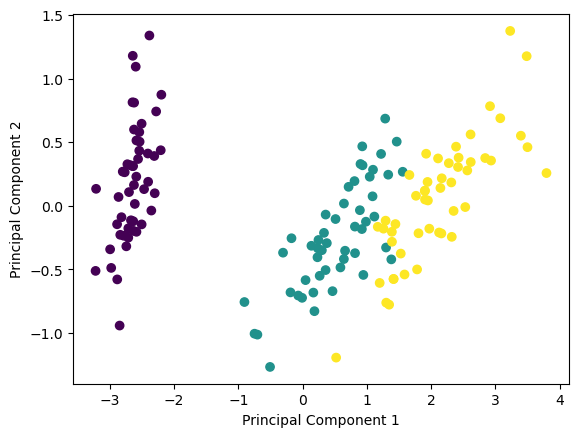

In [13]:
from sklearn.linear_model import Ridge
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

# Regularization: Train a Ridge regression model with L2 regularization
model = Ridge(alpha=0.5)
model.fit(X, y)

# Chi-square test: Calculate the chi-square test statistic and p-value
observed = [[50, 0, 0], [0, 50, 0], [0, 0, 50]]
chi2, p, dof, expected = chi2_contingency(observed)
print(f"Chi-square statistic: {chi2:.2f}")

# PCA: Perform PCA on the Iris dataset and plot the results
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In this example, we're using the Iris dataset and applying L2 regularization using the Ridge regression algorithm with an alpha value of 0.5. We're also performing a chi-square test on a contingency table with equal observed frequencies and calculating the chi-square test statistic and p-value. Finally, we're performing PCA on the Iris dataset and plotting the first two principal components with colors representing the different classes.